# RNAseq differential expression analysis of TEs in Drosophila melanogaster (DmGoth lineage)

## Alignment to TE Consensus sequences

TE consensus sequences are contained in D_mel_transposon_sequence_set.fa (downloaded from https://github.com/bergmanlab/transposons/ )
By aligning reads to these sequences, we can identify which TEs are expressed and get countings.

Commands : 
```
~/softs/minimap2/minimap2 -ax splice ~/cristina_TE/data/consensus/D_mel_transposon_sequence_set.fa ~/cristina_TE/data/reads/FC29.fastq.gz | samtools sort -o FC29.against_consensus.bam

~/softs/minimap2/minimap2 -ax splice ~/cristina_TE/data/consensus/D_mel_transposon_sequence_set.fa ~/cristina_TE/data/reads/FC30.fastq.gz | samtools sort -o FC30.against_consensus.bam
```
We get two bam files as a result (FC29 : 5.2Go, FC30 : 1.8Go )

## Some informations on our reads...

Here's an example of what's in D_mel_transposon_sequence_set.fa : 
```
>1731#LTR/Copia
TGTTGAATATAGGCAATGCCCACATGTGTGTTGAATATAGGCAATTTCCACATGTGCATA
TGTAATTTTGTATGAGAACATACATACATACACATGAACTGTATGTATGTATATATATTA
```

And here's the beginning of the BAM we get by aligning our reads to the TEs consensus sequences : 
```
e1bae963-07b0-44fa-8a67-ae90f86c4ba0    2064    Tc3#DNA/Tc1-Mariner     331     38      710H32M5D19M2D8M1D5M1D18M1D4M1D124M1384H        *       0
       0       GGTTTTACGCTTCTAACTTGACTTCTTGTTTGTTAAATCTCGAAAGTTAAATTCTTTTGATTCTAAATATAAATTATCTTTTTAATTTTTTCTCAAATGGTCCGCGAAAAGTCTTTATCCGATTTTGAAAAAGGTCAAATCAAAGGCTATATTGAATCTGGTTTAAAACACTGTGTAATAGCCAAGAAAATCGGTTGAAGTCAAAACGTT      53/a:/-$7)4/($,%"/$#''-2#"$-5'"''$#'&$%'$"+2%4)*+/)(:?-L/$)2(('#/7+(,$+.#&%(%#&'0-%+(*16995,0.*?;3;9;+*+*/(--)&"%()%8<89210OG?*)NPMPKGC)6>:>*/H5?;-%3/2B4.DLL./A8<:*'A>-"1%#)0255A<*5H2.N(JQ@=J+?@A+-6L7K4)KT1=@WR      NM:i:35 ms:i:115        AS:i:115        nn:i:0  tp:A:P  cm:i:9  s1:i:64 s2:i:0  de:f:0.1389     SA:Z:McClintock#LTR/Gypsy,592,+,1229S153M2I920S,60,11;  rl:i:0
```

We want to count how many reads are aligned on each TEs sequences BUT, we need to remind ourselves that a read can be aligned to several features, then, which one should we count ?

Let's get a look at the alignQC report for FC30.bam
```
alignqc analyze FC30.sorted.bam -g D_mel_transposon_sequence_set.fa -o FC30.consensus.report/FC30.consensus.alignqc.xhtml
```

Well, that didn't work. Seems like a Windows return carriage error ? Maybe this could help :
```
tr -d '\r' < D_mel_transposon_sequence_set.fa > D_mel_transposon_sequence_set.fixed.fa
```
NGS crashed in the meantime, and it did not help : we still got the same error message : 
```
  File "/data/home/ecumunel/.local/lib/python2.7/site-packages/seqtools/errors.py", line 813, in get_context_target_errors
    r[t][tafter]['-']['total'] += 0.5
KeyError: 'Y'
```

Another thing to take into account :
They are primary, secondary, supplementary and unmapped reads. Which one should we count and not count ?
I guess we should discard supplementary alignments and unmapped reads.
Let's check manually how many primary and secondary reads we got.


#### Example case of a supplementary read : e1bae963-07b0-44fa-8a67-ae90f86c4ba0

This read generate two alignments : one primary (in McClintock#LTR/Gypsy) and one supplementary (in Tc3#DNA/Tc1-Mariner). The alignment score is better in the primary. In both case, the alignment covers a very small part of the consensus sequence...



In [1]:
import pysam
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

FC29_bamfile = "data/consensus/bam/FC29.against_consensus.bam"
FC30_bamfile = "data/consensus/bam/FC30.against_consensus.bam"


In [5]:
unmapped = 0
supp = 0
secondary = 0
primary = 0
with pysam.AlignmentFile(FC29_bamfile, 'rb') as bam1:
    for ali in bam1:
        if ali.is_supplementary:
            supp += 1
        elif ali.is_unmapped:
            unmapped += 1
        elif ali.is_secondary:
            secondary += 1
        else:
            primary += 1
print(supp, unmapped, secondary, primary)

424 2918185 953 7369


So we've got around 3 millions unmapped reads, 400 supplementary, 1000 secondary and 7369 primary alignments. This seems very low, but considering we only aligned against TE consensus sequences, which is like 2% of the transcriptome, it's actually not so bad. And FC29 is the smallest dataset.

A more helpful number should be the number of single mapped read (read that mapped to only one feature)  
TODO : fix the following script.

In [17]:
FC29_alignments = pysam.AlignmentFile(FC29_bamfile, 'rb')
read_index = pysam.IndexedReads(FC29_alignments)
read_index.build()

FileNotFoundError: [Errno 2] could not open alignment file `data/consensus/bam/FC29.against_consensus.bam`: No such file or directory



## Getting the expression level of each TE

We can extrapolate the expression level of a said TE from the number of reads that mapped on its consensus sequence.
A table representing the counting of each feature between female and male. A ratio would be preferable as we have fewer reads from female to work with. Only primary read are being counted.

Let's gather our data into a python dict first : 

In [3]:
def get_countings_from_bam(bamfile):
    counting_dict = dict()
    alignment_file = pysam.AlignmentFile(bamfile, 'rb')
    for ali in alignment_file:
        if not ali.is_secondary and not ali.is_supplementary and not ali.is_unmapped :
            if not ali.reference_name in counting_dict :
                counting_dict[ali.reference_name] = 0
            counting_dict[ali.reference_name] += 1
    return counting_dict

consensus_counting_female_dict = get_countings_from_bam(FC29_bamfile)
consensus_counting_male_dict = get_countings_from_bam(FC30_bamfile)

full_consensus_counting_dict = dict()
for feature in consensus_counting_female_dict:
    if not feature in consensus_counting_male_dict :
        full_consensus_counting_dict[feature] = [consensus_counting_female_dict[feature], 0]
    else :
        full_consensus_counting_dict[feature] = [consensus_counting_female_dict[feature], consensus_counting_male_dict[feature]]

for feature in consensus_counting_male_dict:
    if not feature in consensus_counting_female_dict :
        full_consensus_counting_dict[feature] = [0, consensus_counting_male_dict[feature]]

total_count_female = 0
total_count_male = 0
for count_female, count_male in full_consensus_counting_dict.values():
    total_count_female += count_female
    total_count_male += count_male

full_consensus_ratio_dict = dict()
for feature, counting in full_consensus_counting_dict.items():
    female_ratio = 0 if counting[0] == 0 else counting[0]/total_count_female
    male_ratio = 0 if counting[1] == 0 else counting[1]/total_count_male
    full_consensus_ratio_dict[feature] = [female_ratio, male_ratio]


## Exporting results to csv...

In [ ]:
consensus_counting_df = pd.DataFrame.from_dict(full_consensus_counting_dict)
consensus_counting_df = consensus_counting_df.T
consensus_counting_df.columns = ["Female", "Male"]
consensus_counting_df.index.name = "ID"

consensus_counting_df.to_csv("consensus_counting.csv")

consensus_ratio_df = pd.DataFrame.from_dict(full_consensus_ratio_dict)
consensus_ratio_df = consensus_ratio_df.T
consensus_ratio_df.columns = ["Female", "Male"]
consensus_ratio_df.index.name = "TE"

consensus_ratio_df.to_csv("consensus_TE_ratio.csv")

## Importing results from CSV

In [28]:
consensus_ratio_df = pd.read_csv("consensus_TE_ratio.csv", index_col="TE")
consensus_counting_df = pd.read_csv("consensus_counting.csv", index_col="ID")

consensus_ratio_df.head()
# consensus_counting_df.head()

,Female,Male
TE,,
Tc3#DNA/Tc1-Mariner,0.000543,0.000000
1731#LTR/Copia,0.005292,0.000000
mdg3#LTR/Gypsy,0.000814,0.000000
mdg1#LTR/Gypsy,0.001493,0.003239
gypsy#LTR/Gypsy,0.003121,0.000810


## Barplot of TE expression ratio (from consensus data)

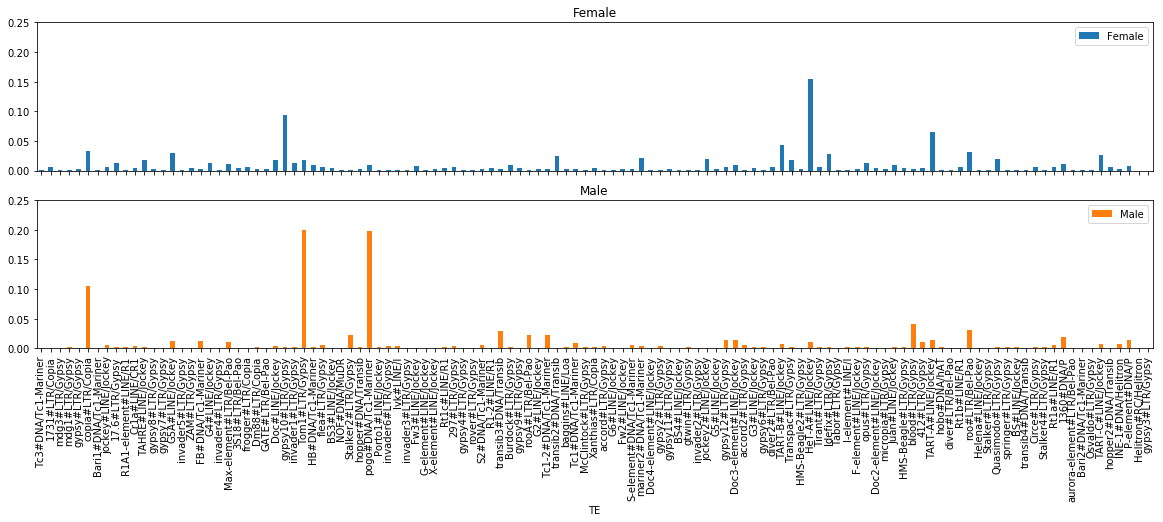

In [12]:
axs = consensus_ratio_df.plot.bar(figsize=(20,6), subplots=True, ylim=(0, 0.25))

## Generating the dataframe : Counts per Superfamily, family, and TE

In [29]:
consensus_TE_counts_df = consensus_counting_df.copy()

te_names = []
te_familys = []
te_super_familys = []
for te in consensus_TE_counts_df.index :
    te_name, te_super_family, te_family = re.split('#|/', te)
    te_names.append(te_name)
    te_familys.append(te_family)
    te_super_familys.append(te_super_family)


consensus_TE_counts_df.insert(0, "TE", te_names)
consensus_TE_counts_df.insert(1, "Family", te_familys)
consensus_TE_counts_df.insert(2, "SuperFamily", te_super_familys)
consensus_TE_counts_df.head()


,TE,Family,SuperFamily,Female,Male
ID,,,,,
Tc3#DNA/Tc1-Mariner,Tc3,Tc1-Mariner,DNA,4,0
1731#LTR/Copia,1731,Copia,LTR,39,0
mdg3#LTR/Gypsy,mdg3,Gypsy,LTR,6,0
mdg1#LTR/Gypsy,mdg1,Gypsy,LTR,11,4
gypsy#LTR/Gypsy,gypsy,Gypsy,LTR,23,1


## Pie plots : Ratio of each superfamily / family / TE

In [18]:
consensus_TE_counts_df.head()

subject_coverage = {'1360#DNA/P': 0.23814919406908722,
 '17.6#LTR/Gypsy': 0.17451056462167872,
 '1731#LTR/Copia': 0.7549963814775318,
 '297#LTR/Gypsy': 0.19410695118529087,
 '3S18#LTR/Bel-Pao': 0.6616492162041253,
 '412#LTR/Gypsy': 0.38163653576744405,
 'BS#LINE/Jockey': 0.6711858279242352,
 'BS3#LINE/Jockey': 0.4256935177861922,
 'BS4#LINE/Jockey': 0.5896125631129719,
 'Bari1#DNA/Tc1-Mariner': 0.17251131221719457,
 'Bari2#DNA/Tc1-Mariner': 0.5680997257977848,
 'Burdock#LTR/Gypsy': 0.4931699368368139,
 'Circe#LTR/Gypsy': 0.6381200794426465,
 'Cr1a#LINE/CR1': 0.18226377821386594,
 'Dm88#LTR/Copia': 0.6048957043959605,
 'Doc#LINE/Jockey': 0.2982921910442708,
 'Doc2-element#LINE/Jockey': 0.5558526241507369,
 'Doc3-element#LINE/Jockey': 0.45868206372853154,
 'Doc4-element#LINE/Jockey': 0.42241458583482877,
 'F-element#LINE/Jockey': 0.3279888519313895,
 'FB#DNA/Tc1-Mariner': 0.15835056451880108,
 'Fw2#LINE/Jockey': 0.45211058394208786,
 'Fw3#LINE/Jockey': 0.5853060947944358,
 'G-element#LINE/Jockey': 0.9538188277087034,
 'G2#LINE/Jockey': 0.15411090981788422,
 'G3#LINE/Jockey': 0.38810582648525893,
 'G4#LINE/Jockey': 0.5598848691481366,
 'G5#LINE/Jockey': 0.3372175658717751,
 'G5A#LINE/Jockey': 0.5510070019092954,
 'G6#LINE/Jockey': 0.20814056670953135,
 'G7#LINE/Jockey': 0,
 'GATE#LTR/Bel-Pao': 0.5469017692335241,
 'HB#DNA/Tc1-Mariner': 0.6217809055712581,
 'HMS-Beagle#LTR/Gypsy': 0.6039896207168451,
 'HMS-Beagle2#LTR/Gypsy': 0.2766563257031705,
 'HeT-A#LINE/Jockey': 0.5872923027182045,
 'Helena#LINE/Jockey': 0.21415963914493039,
 'Helitron#RC/Helitron': 0,
 'I-element#LINE/I': 0.386451388858954,
 'INE-1#DNA/Helitron': 0.11487010929054726,
 'Idefix#LTR/Gypsy': 0.26964400773987485,
 'Ivk#LINE/I': 0.41321148950006936,
 'Juan#LINE/Jockey': 0.14355153730797698,
 'Max-element#LTR/Bel-Pao': 0.4610615082236414,
 'McClintock#LTR/Gypsy': 0.5983114758841271,
 'NOF#DNA/MuDR': 0.4104413406091121,
 'Osvaldo#LTR/Gypsy': 0.20150286119041239,
 'P-element#DNA/P': 0.47915006263233206,
 'Porto1#LINE/Jockey': 0.6826254826254826,
 'Q-element#LINE/CR1': 0,
 'Quasimodo#LTR/Gypsy': 0.3730601023166533,
 'R1-2#LINE/R1': 0.3893272402191255,
 'R1A1-element#LINE/R1': 0.5868596881959911,
 'R2-element#LINE/R2': 0,
 'Rt1a#LINE/R1': 0.22809938794292584,
 'Rt1b#LINE/R1': 0.5508251212030406,
 'Rt1c#LINE/R1': 0.5241786004786663,
 'S-element#DNA/Tc1-Mariner': 0.2650004639651015,
 'S2#DNA/Tc1-Mariner': 0.14363943537352988,
 'Stalker#LTR/Gypsy': 0.508953172982279,
 'Stalker2#LTR/Gypsy': 0.3142516258008672,
 'Stalker3#LTR/Gypsy': 0,
 'Stalker4#LTR/Gypsy': 0.26567091133842047,
 'TAHRE#LINE/Jockey': 0.5148306483640447,
 'TART-A#LINE/Jockey': 0.609513787563766,
 'TART-B#LINE/Jockey': 0.7426961670218676,
 'TART-C#LINE/Jockey': 0.6970275607402963,
 'Tabor#LTR/Gypsy': 0.3140626804054503,
 'Tc1#DNA/Tc1-Mariner': 0.2160851116497139,
 'Tc1-2#DNA/Tc1-Mariner': 0.14230296912684134,
 'Tc3#DNA/Tc1-Mariner': 0.6704925812693976,
 'Tirant#LTR/Gypsy': 0.5804910294109141,
 'Tom1#LTR/Gypsy': 0.12805370258438808,
 'Transpac#LTR/Gypsy': 0.4823820802392803,
 'X-element#LINE/Jockey': 0.5922711179867403,
 'Xanthias#LTR/Copia': 0.608824945139743,
 'ZAM#LTR/Gypsy': 0.626380900085638,
 'accord#LTR/Gypsy': 0.17685242725953207,
 'accord2#LTR/Gypsy': 0.4086452809407833,
 'aurora-element#LTR/Bel-Pao': 0.5356792521313135,
 'baggins#LINE/Loa': 0.25731802255128666,
 'blood#LTR/Gypsy': 0.11645544610363813,
 'copia#LTR/Copia': 0.7419526331791337,
 'diver#LTR/Bel-Pao': 0.6161254890167301,
 'diver2#LTR/Bel-Pao': 0.5925499082400968,
 'flea#LTR/Gypsy': 0.641335447480838,
 'frogger#LTR/Copia': 0.6266414733169761,
 'gtwin#LTR/Gypsy': 0.5287958115183246,
 'gypsy#LTR/Gypsy': 0.49737901522675426,
 'gypsy10#LTR/Gypsy': 0.6943481069574583,
 'gypsy11#LTR/Gypsy': 0.4969449060449328,
 'gypsy12#LTR/Gypsy': 0.4537946838910319,
 'gypsy2#LTR/Gypsy': 0.3876446799950242,
 'gypsy3#LTR/Gypsy': 0,
 'gypsy4#LTR/Gypsy': 0.43511455786925257,
 'gypsy5#LTR/Gypsy': 0,
 'gypsy6#LTR/Gypsy': 0.528852158855894,
 'gypsy7#LTR/Gypsy': 0.31393568147013784,
 'gypsy8#LTR/Gypsy': 0.46920918815011553,
 'gypsy9#LTR/Gypsy': 0.6515791363980189,
 'hobo#DNA/hAT': 0.325983450258182,
 'hopper#DNA/Transib': 0.5297317006268296,
 'hopper2#DNA/Transib': 0.5082832203948243,
 'invader1#LTR/Gypsy': 0.41744277822505677,
 'invader2#LTR/Gypsy': 0.6443861491710994,
 'invader3#LTR/Gypsy': 0.5829353040243218,
 'invader4#LTR/Gypsy': 0.496848210623271,
 'invader5#LTR/Gypsy': 0.0619647355163728,
 'invader6#LTR/Gypsy': 0.6545529031378721,
 'jockey#LINE/Jockey': 0.38933517291421577,
 'jockey2#LINE/Jockey': 0.3374662999149359,
 'looper1#DNA/PiggyBac': 0,
 'mariner2#DNA/Tc1-Mariner': 0.5038019877075689,
 'mdg1#LTR/Gypsy': 0.5707003109731349,
 'mdg3#LTR/Gypsy': 0.47408320732739323,
 'micropia#LTR/Gypsy': 0.4382835958279644,
 'opus#LTR/Gypsy': 0.6124791776217741,
 'pogo#DNA/Tc1-Mariner': 0.4780134516813894,
 'roo#LTR/Bel-Pao': 0.2750597496968646,
 'rooA#LTR/Bel-Pao': 0.4203840272956479,
 'rover#LTR/Gypsy': 0.2294079150044345,
 'springer#LTR/Gypsy': 0.46854589205912683,
 'transib1#DNA/Transib': 0,
 'transib2#DNA/Transib': 0.5087089397152094,
 'transib3#DNA/Transib': 0.5678020530702458,
 'transib4#DNA/Transib': 0.4782851061777222}

In [24]:
consensus_TE_counts_df.head()

,TE,Family,SuperFamily,Female,Male
ID,,,,,
Tc3#DNA/Tc1-Mariner,Tc3,Tc1-Mariner,DNA,4,0
1731#LTR/Copia,1731,Copia,LTR,39,0
mdg3#LTR/Gypsy,mdg3,Gypsy,LTR,6,0
mdg1#LTR/Gypsy,mdg1,Gypsy,LTR,11,4
gypsy#LTR/Gypsy,gypsy,Gypsy,LTR,23,1


In [30]:
consensus_TE_counts_df['Male_subject_coverage'] = consensus_TE_counts_df.index.to_series().map(subject_coverage)
consensus_TE_counts_df.head()

,TE,Family,SuperFamily,Female,Male,Male_subject_coverage
ID,,,,,,
Tc3#DNA/Tc1-Mariner,Tc3,Tc1-Mariner,DNA,4,0,0.670493
1731#LTR/Copia,1731,Copia,LTR,39,0,0.754996
mdg3#LTR/Gypsy,mdg3,Gypsy,LTR,6,0,0.474083
mdg1#LTR/Gypsy,mdg1,Gypsy,LTR,11,4,0.570700
gypsy#LTR/Gypsy,gypsy,Gypsy,LTR,23,1,0.497379


In [16]:
df = consensus_TE_counts_df.copy()
fig = px.pie(df, values='Female', names='Family')
fig.show()

In [32]:
df = px.data.gapminder().query("year == 2007")
df.head()

,country,continent,year,lifeExp,pop,gdpPercap,iso_alpha,iso_num
11,Afghanistan,Asia,2007,43.828,31889923,974.580338,AFG,4
23,Albania,Europe,2007,76.423,3600523,5937.029526,ALB,8
35,Algeria,Africa,2007,72.301,33333216,6223.367465,DZA,12
47,Angola,Africa,2007,42.731,12420476,4797.231267,AGO,24
59,Argentina,Americas,2007,75.320,40301927,12779.379640,ARG,32


In [38]:
import dtale

In [40]:
dtale.show(df)


In [41]:
# df = px.data.gapminder().query("year == 2007")
# fig = px.sunburst(df, path=['continent', 'country'], values='pop',
#                   color='lifeExp', hover_data=['iso_alpha'])
# fig.show()

df = consensus_TE_counts_df.copy()
df.fillna(0, inplace=True)
fig = px.sunburst(df, path=['SuperFamily', 'Family'], color='Male_subject_coverage', values='Male', hover_data=['Male'])
fig.show()



ZeroDivisionError: Weights sum to zero, can't be normalized

#### Some trouble with the query coverage of some TEs...

The query coverage of some TE can be very low, as seen here on IGV for 1731#LTR/Copia :
![title](doc/low_QC_for_Copia.png)

When we blatted the sequence of read e687c074-c5e2-4c85-9ba0-492e6a4a8a84 (in black on previous picture), this is what we got :  

![title](doc/copia_blat_recap.png)




Our read is divided in at least four part : 
* Gene1 in orange (4 -> 1464) | FBtr0081639 (= alphaTub84B)
* Gene2 in green (1500 -> 2317) | FBtr0079204 (=CG13989)
* Copia in pink (2385 -> 4141)
* Gene3 in purple (4208 -> 5529) | FBtr0301683 (=Sinah)


One part of our read (in pink from 2385 to 4145) is aligned a bunch of time against the duplication 1731 of Copia, in several chromosomes (which is normal for a TE). Another one (in orange from 4 to 1464) is aligned three time to genes coding for a very similar protein (FBtr0081639 = alphaTub84B, which is a gene from chr3R:7086599-7088839, FBtr0081538 =alphaTub84D, another gene from chr3R:7530753-7532732 and FBtr0082087 =alphaTub85E, from chr3R:9731221-9733250).

This read seems to be chimeric : it looks like several reads glued together. To check if it is the case, we could have a look at the different sequence between each part. Maybe it's a redundant sequence that we could find in other reads, in which case it would suggest that it is an adaptator or something... We should align this in-between sequence and check if we can find it elsewhere.


In [7]:

black_read = read_index.find("e687c074-c5e2-4c85-9ba0-492e6a4a8a84")
black_read_sequence = list(black_read)[0].query_sequence
orange2green = black_read_sequence[1464:1500]
green2pink = black_read_sequence[2317:2385]
pink2purple = black_read_sequence[4141:4208]

print(len(orange2green))
print(len(green2pink))
print(len(pink2purple))

print(orange2green)
print(green2pink)
print(pink2purple)


36
68
67
AAAAAAACACCTAAGATCTCAGGCGTTTTTTTGCAT
GTAGGGATCTATAGTGAGTCGTATTACATATCAATCCATGGATTGATATGTAATCAAGCTGCACTTAA
TAATGATCGTTGTATAAAAAAAAAACCCCTGAGATCCGCAGCGTTTTTTTTTTTTTTGATTATAGCC


Only pink2purple has a blat result.
Let's compare those sequences to another read aligned to copia dup 1731 (7596c024-a22d-48a3-b6e4-ec4d75980c0a)


In [11]:
new_read = read_index.find("7596c024-a22d-48a3-b6e4-ec4d75980c0a")
new_read_sequence = list(new_read)[0].query_sequence
green2pink_2 = new_read_sequence[1502:1575]
pink2orange_2 = new_read_sequence[3362:3419]
print(green2pink_2)
print(pink2orange_2)



CTATAGTGAGTCATTGTTACATATCAATCCATGGATTGATATGTAATACGAGCTGCACATGTAACTGTACTAG
ATTAAAAAAAAAAAAACGCCTGAGATGGATTGATATGTAATACGACTCACTATTAAG


The new read can be divided in 3 parts : Copia, gene1 and gene2.
![title](doc/new_read_blat.png)

### Get the mean query coverage of each TE

first, we need the list of chromosome :

In [7]:
import pprint

chrom_list = []
with open("data/consensus/D_mel_transposon_sequence_set.fa", 'r') as genome:
    for line in genome:
        if line.startswith(">"):
            chrom_list.append(line[1:].strip())

FC29_alignments = pysam.AlignmentFile(FC29_bamfile)

chrom_lengths_dict = {chrom_list[i]: FC29_alignments.lengths[i] for i in range(len(chrom_list))}
TE_query_coverage = dict()
for chrom, chrom_length in chrom_lengths_dict.items():
    ali_iter = FC29_alignments.fetch(chrom)
    query_coverage_list = []
    for ali in ali_iter:
        if not ali.is_secondary and not ali.is_supplementary:
            read_length = ali.infer_read_length()
            mapped_length = ali.query_alignment_length
            query_coverage = mapped_length / read_length
            query_coverage_list.append(query_coverage)

    if len(query_coverage_list) == 0 :
        TE_query_coverage[chrom] = 0
    else: 
        mean_query_coverage = sum(query_coverage_list) / len(query_coverage_list)
        TE_query_coverage[chrom] = mean_query_coverage

pprint.pprint(TE_query_coverage)

{'1360#DNA/P': 0.23814919406908722,
 '17.6#LTR/Gypsy': 0.17451056462167872,
 '1731#LTR/Copia': 0.7549963814775318,
 '297#LTR/Gypsy': 0.19410695118529087,
 '3S18#LTR/Bel-Pao': 0.6616492162041253,
 '412#LTR/Gypsy': 0.38163653576744405,
 'BS#LINE/Jockey': 0.6711858279242352,
 'BS3#LINE/Jockey': 0.4256935177861922,
 'BS4#LINE/Jockey': 0.5896125631129719,
 'Bari1#DNA/Tc1-Mariner': 0.17251131221719457,
 'Bari2#DNA/Tc1-Mariner': 0.5680997257977848,
 'Burdock#LTR/Gypsy': 0.4931699368368139,
 'Circe#LTR/Gypsy': 0.6381200794426465,
 'Cr1a#LINE/CR1': 0.18226377821386594,
 'Dm88#LTR/Copia': 0.6048957043959605,
 'Doc#LINE/Jockey': 0.2982921910442708,
 'Doc2-element#LINE/Jockey': 0.5558526241507369,
 'Doc3-element#LINE/Jockey': 0.45868206372853154,
 'Doc4-element#LINE/Jockey': 0.42241458583482877,
 'F-element#LINE/Jockey': 0.3279888519313895,
 'FB#DNA/Tc1-Mariner': 0.15835056451880108,
 'Fw2#LINE/Jockey': 0.45211058394208786,
 'Fw3#LINE/Jockey': 0.5853060947944358,
 'G-element#LINE/Jockey': 0.953818

TODO : Get the subject coverage


# Countings by position from genomic alignments

In [27]:
female_count_by_pos_df = pd.read_csv("results/transcript_id_FC29_counts/FC29_transcript_id_counts.filtered", sep='\t', header = None, names=['ID', 'chrom', 'start', 'end', 'strand', 'length', 'count_female'], index_col = "ID")
female_count_by_pos_df.head()

# Male
male_count_by_pos_df = pd.read_csv("results/transcript_id_FC30_counts/FC30_transcript_id_counts.filtered", sep='\t', header = None, names=['ID', 'chrom', 'start', 'end', 'strand', 'length', 'count_male'], index_col = "ID")
male_count_by_pos_df.head()

versus_count_df = pd.concat([female_count_by_pos_df, male_count_by_pos_df])
versus_count_df.fillna(0, inplace=True)
versus_count_df.head()

,chrom,start,end,strand,length,count_female,count_male
ID,,,,,,,
DNAREP1_DM_4_RaGOO_1132_1263,4_RaGOO,1132,1263,+,132,1.0,0.0
QUASIMODO2-LTR_DM_4_RaGOO_13230_19659,4_RaGOO,13230,19659,+,6430,1.0,0.0
DNAREP1_DM_4_RaGOO_152028_152132,4_RaGOO,152028,152132,+,105,2.0,0.0
PROTOP_B_4_RaGOO_175159_176280,4_RaGOO,175159,176280,+,1122,5.0,0.0
DNAREP1_DM_4_RaGOO_186866_187247,4_RaGOO,186866,187247,.,382,2.0,0.0
